In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json
import re
from scipy.spatial.distance import pdist,squareform
import ast

<h2>Computing a Euclidean distance matrix for pairs of dimensions for each participant</h2>

<p>After computing the euclidean distance matrices for each participant, we will use this to calculate subjective distances and assign them to columns</p>

<ol>
<li>Find rows in the dataframe where df["Choice_trial"] is true, and then get the two preceding rows for the choice trial row t-1 and t-2. 
</li>
<li>Get df["Colour_stim"], df["Texture_stim"], df["Shape_stim"] from the preceding trial and as well as two trials before so t-2. 
</li>
<li>Get df["Colour_distractor"], df["Texture_distractor"], df["Shape_distractor"] which are integers, then grab the appropriate from pp_colour_order etc respectively, add it to the column "Distractor_SubjDist_Colour" and so on for all the dimensions. </li>
<li>From the distance matrix then get the euclidean distance : for example the distance between distractor_colour and stim_colour from the preceding trial
</li>
<li>Also compare the colour_distractor and stim_colour_t-2 and update Distractor_identical_Colour(t-2) if they are the same value with 1 else 0. Repeat for the other dimensions as well</li>
</ol>



In [ ]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]


for index, participant in enumerate(datasets):

    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    participant_id = df["ppID"].unique()[0]

    columns_to_add = {
        "Distractor_trueDist_Colour":None, #true distance is the minimum distance between the current distractor colour node and the colour node of the previous stimulus object
        #true distance is basically, how many nodes away is my current distractor node from that of the previous object 
        "Distractor_trueDist_Texture":None,
        "Distractor_trueDist_Shape":None,
        #subjective distance is the same as above, but it is calculated using the subjective perception of the distance of the distractor node 
        #to the node of the previous object. The distances are the euclidean distances of the the pairs of stimuli dimensions, as arranged
        #by the participants in the sorting task 
        "Distractor_SubjDist_Colour":None,
        "Distractor_SubjDist_Texture":None,
        "Distractor_SubjDist_Shape":None,
        
        #these columns are to check if the distractor is identical to the stimulus object two trials before the choice trial. 
        #this is for our model, to check if there could be a possible repetition effect, where participants may choose a distractor
        #and thus reduce accuracy, because used an identical feature from two trials ago. Ergo, use the repetition of a stimulus to make choices
        # and not an internalized graph structure 
        "Distractor_identical_Colour(t-2)":None,
        "Distractor_identical_Texture(t-2)":None,
        "Distractor_identical_Shape(t-2)":None,
    }

    for column in columns_to_add.keys():
        df[column] = np.nan


    #use these to then grab the subjective distances from the distance matrices
    pp_colour_order = df["Colour_Graph"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x
    ).iloc[0]
    pp_texture_order = df["Texture_Graph"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x
    ).iloc[0]
    pp_texture_order = [i.split("texture/")[-1] for i in pp_texture_order] #remove the texture/ part of the string 
    pp_shape_order = df["Shape_Graph"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x
    ).iloc[0]


    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    colour_arrangement_data = {}
    texture_arrangement_data  = {}
    shape_arrangement_data = {}

    dist_matrix_colour = None
    dist_matrix_texture = None
    dist_matrix_shape = None

    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            dimension = data['src'].split("/")[0] #strip everything after the /
            feature = re.sub(r'.*/|\.png$','', data['src'])
            x = data['x']
            y = data['y']
            if "Texture" in dimension:
                texture_arrangement_data[feature] = [x,y]
            elif "Colour" in dimension:
                colour_arrangement_data[feature] = [x,y]
            else:
                shape_arrangement_data[feature] = [x,y]
    

            if colour_arrangement_data and texture_arrangement_data and shape_arrangement_data:
                colour_df = pd.DataFrame(colour_arrangement_data).T
                texture_df = pd.DataFrame(texture_arrangement_data).T
                shape_df = pd.DataFrame(shape_arrangement_data).T

                dist_matrix_colour = pd.DataFrame(
                    squareform(pdist(colour_df,metric="euclidean")),
                    index=colour_df.index,
                    columns = colour_df.index
                )

                dist_matrix_texture = pd.DataFrame(
                    squareform(pdist(texture_df,metric="euclidean")),
                    index=texture_df.index,
                    columns = texture_df.index
                )

                dist_matrix_shape = pd.DataFrame(
                    squareform(pdist(shape_df,metric="euclidean")),
                    index=shape_df.index,
                    columns = shape_df.index
                )

                # dist_matrix_colour.to_csv(f"Distance Matrices Dimensions/{participant_id}_Colour_DistMatrix.csv")
                # dist_matrix_texture.to_csv(f"Distance Matrices Dimensions/{participant_id}_Texture_DistMatrix.csv")
                # dist_matrix_shape.to_csv(f"Distance Matrices Dimensions/{participant_id}_Shape_DistMatrix.csv")
            
    #grab all the indices where we have choice trials
    choice_trial_indices = df.index[df["Choice Trial Index"].notna()].tolist()

    for row_index in choice_trial_indices:
        #get current distractor nodes at row_index which is trial (t)
        distractor_colour = df.at[row_index,"Colour_distractor"]
        distractor_texture = df.at[row_index,"Texture_distractor"]
        distractor_shape = df.at[row_index,"Shape_distractor"]

        #grab the corresponding node from the graph order because it is different for each participant
        dist_colour_label = pp_colour_order[int(distractor_colour)]
        dist_texture_label = pp_texture_order[int(distractor_texture)]
        dist_shape_label = pp_shape_order[int(distractor_shape)]
        
        #get nodes of preceding stimulus object so (t-1)
        stim_colour_t1 = df.at[row_index-1, "Colour_stim"]
        stim_texture_t1 = df.at[row_index-1, "Colour_texture"]
        stim_shape_t1 = df.at[row_index-1, "Colour_shape"]

        stim_colour_label = pp_colour_order[int(stim_colour_t1)]
        stim_texture_label = pp_texture_order[int(stim_texture_t1)]
        stim_shape_label = pp_shape_order[int(stim_shape_t1)]

        #get nodes of stimulus objet from t-2
        stim_colour_t2 = df.at[row_index-2, "Colour_stim"]
        stim_texture_t2 = df.at[row_index-2, "Colour_texture"]
        stim_shape_t2 = df.at[row_index-2, "Colour_shape"]

        #now fetch subjective distances from our already generated distance matrices
        subj_dist_colour = dist_matrix_colour.at[dist_colour_label, stim_colour_label]
        subj_dist_texture = dist_matrix_texture.at[dist_texture_label, stim_texture_label]
        subj_dist_shape = dist_matrix_shape.at[dist_matrix_shape,stim_shape_label]

        #for all t-2 trials check if the distractor node is identical to the stimulus object node
        identical_colour = 1 if distractor_colour == stim_colour_t2 else 0
        identical_texture = 1 if distractor_texture == stim_texture_t2 else 0
        identical_shape = 1 if distractor_shape == stim_shape_t2 else 0

        df.at[row_index,"Distractor_SubjDist_Colour"] = subj_dist_colour
        df.at[row_index,"Distractor_SubjDist_Texture"] =  subj_dist_texture
        df.at[row_index,"Distractor_SubjDist_Shape"] = subj_dist_shape

        df.at[row_index,"Distractor_identical_Colour(t-2)"] =identical_colour
        df.at[row_index,"Distractor_identical_Texture(t-2)"] = identical_texture
        df.at[row_index,"Distractor_identical_Shape(t-2)"] = identical_shape

        df.to_csv()



    

4.0
5.0
2.0
1.0
1.0
2.0
4.0
0.0
2.0
1.0
1.0
3.0
4.0
1.0
2.0
5.0
2.0
2.0
3.0
2.0
2.0
2.0
3.0
1.0
3.0
3.0
5.0
5.0
4.0
0.0
5.0
4.0
1.0
0.0
1.0
0.0
5.0
1.0
4.0
0.0
2.0
5.0
0.0
0.0
5.0
4.0
4.0
4.0
0.0
4.0
1.0
1.0
5.0
4.0
2.0
5.0
5.0
1.0
2.0
3.0
2.0
1.0
2.0
0.0
2.0
5.0
3.0
1.0
0.0
0.0
4.0
5.0
3.0
5.0
0.0
1.0
4.0
4.0
0.0
0.0
5.0
2.0
5.0
3.0
5.0
3.0
5.0
1.0
3.0
4.0
1.0
0.0
3.0
2.0
2.0
2.0
0.0
4.0
0.0
1.0
2.0
5.0
4.0
0.0
1.0
3.0
4.0
5.0
1.0
1.0
2.0
5.0
3.0
4.0
2.0
4.0
4.0
5.0
1.0
3.0
3.0
0.0
4.0
1.0
3.0
4.0
0.0
3.0
2.0
3.0
4.0
2.0
1.0
1.0
3.0
3.0
1.0
4.0
3.0
4.0
2.0
2.0
1.0
4.0
2.0
0.0
5.0
3.0
2.0
2.0
5.0
0.0
0.0
0.0
3.0
0.0
0.0
2.0
4.0
4.0
1.0
0.0
0.0
3.0
2.0
2.0
3.0
2.0
4.0
3.0
4.0
3.0
4.0
1.0
3.0
4.0
0.0
1.0
1.0
4.0
2.0
4.0
1.0
1.0
2.0
1.0
5.0
2.0
2.0
5.0
0.0
1.0
2.0
5.0
1.0
4.0
5.0
0.0
1.0
3.0
0.0
1.0
0.0
2.0
1.0
1.0
3.0
1.0
2.0
3.0
2.0
1.0
0.0
5.0
5.0
3.0
2.0
3.0
2.0
5.0
0.0
3.0
5.0
0.0
0.0
3.0
1.0
2.0
5.0
0.0
3.0
5.0
1.0
2.0
4.0
3.0
4.0
2.0
2.0
2.0
0.0
2.0
4.0
3.0
3.0
3.0
5.0
4.0
0.0
3.0


<h2>Plotting arrangements of stimuli for each dimension, from second block</h2>

<h3>Colour dimension</h3>

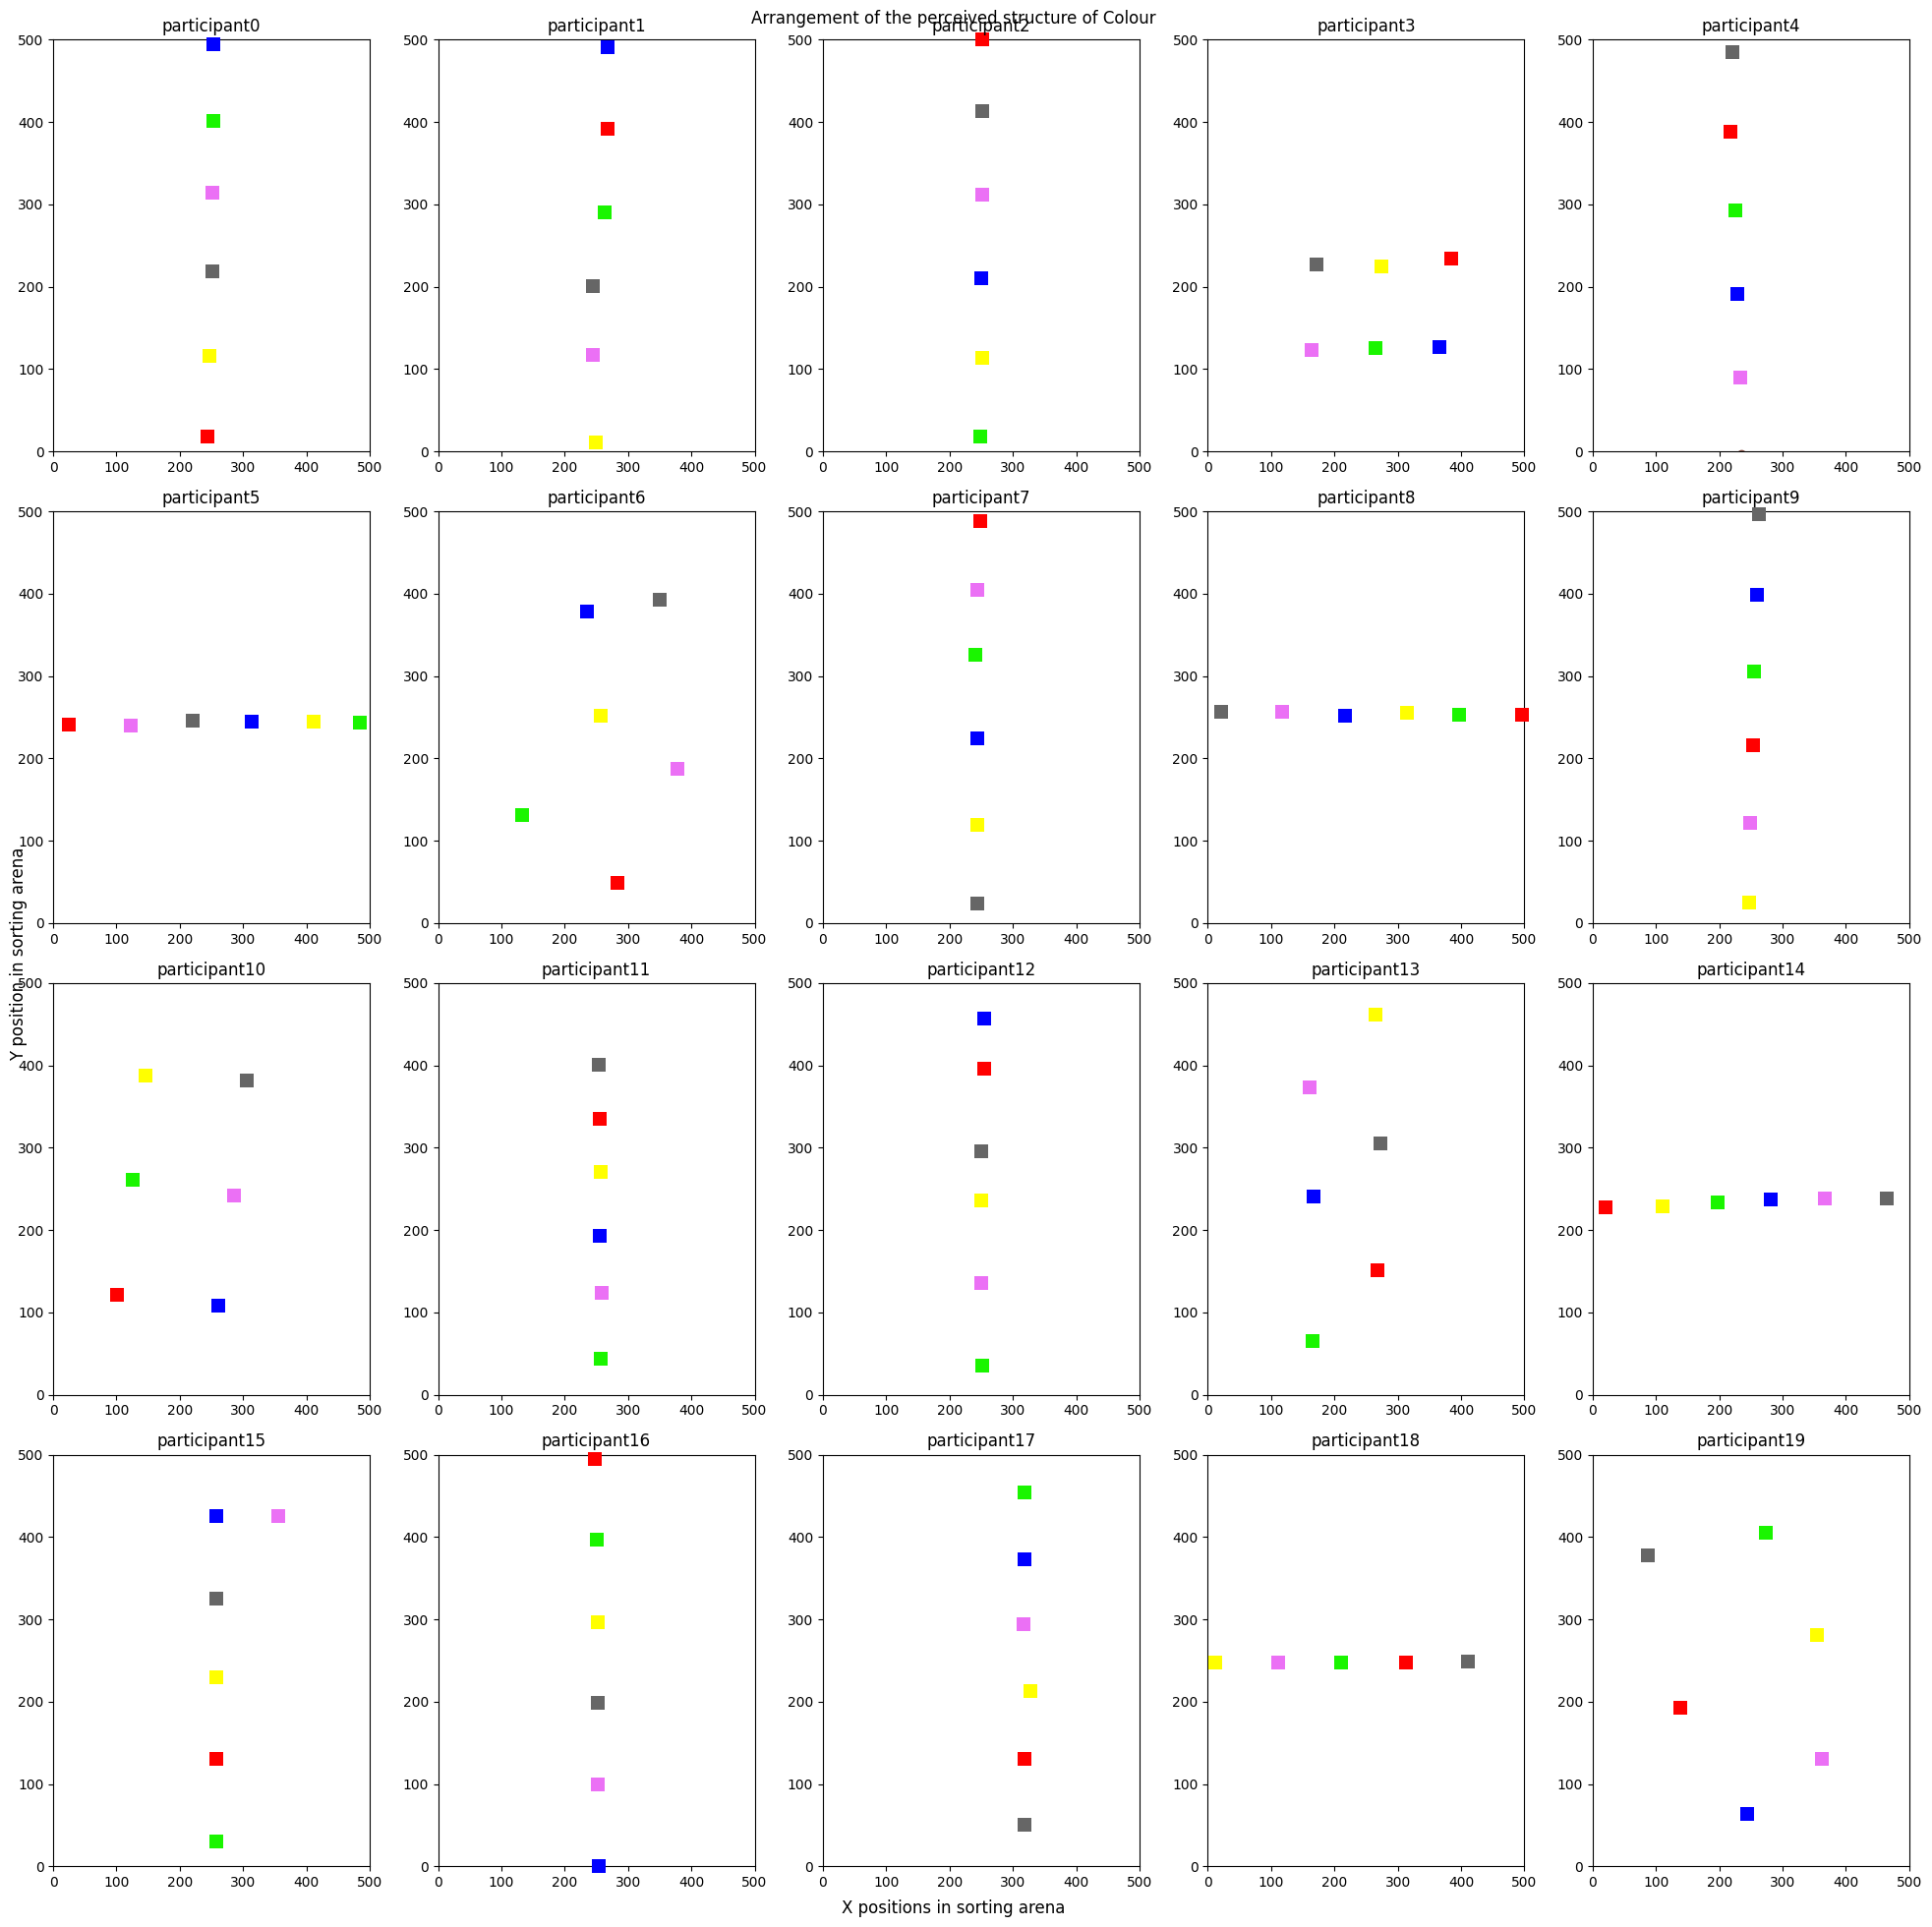

In [11]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]
cols = 5
rows = len(datasets) // cols
figsize = (20,20)
fig, axes = plt.subplots(rows, cols, figsize=figsize)
criteria_match = "Colour"



for index, participant in enumerate(datasets):
    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    plot_data = {}
    ax = axes.flatten()[index]

    #loop through all the objects and find the location data for the colours
    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            if criteria_match in data['src']:
                image = data['src']
                x = data['x']
                y = data['y']
                plot_data[image] = [x,y]
            else:
                continue


    #now loop through the plot data and plot them on their respective subplot
    for key in plot_data:
        image_path = key
        x_coord = plot_data[key][0]
        y_coord = plot_data[key][1]
        ax.set_title(f"participant{index}")
        ax.scatter(x_coord,y_coord)
        ax.set_xlim([0,500])
        ax.set_ylim([0,500])
        img =  Image.open(f"{image_path}")
        img.thumbnail((10,10))
        img_array = np.asarray(img)
        imagebox = OffsetImage(img_array,zoom=1)
        #this is the picture which gets overlayed on the scatter
        picture = AnnotationBbox(imagebox, (x_coord,y_coord), frameon=False)
        ax.add_artist(picture)


fig.suptitle(f"Arrangement of the perceived structure of {criteria_match}")
fig.supxlabel("X positions in sorting arena")
fig.supylabel("Y position in sorting arena")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

    


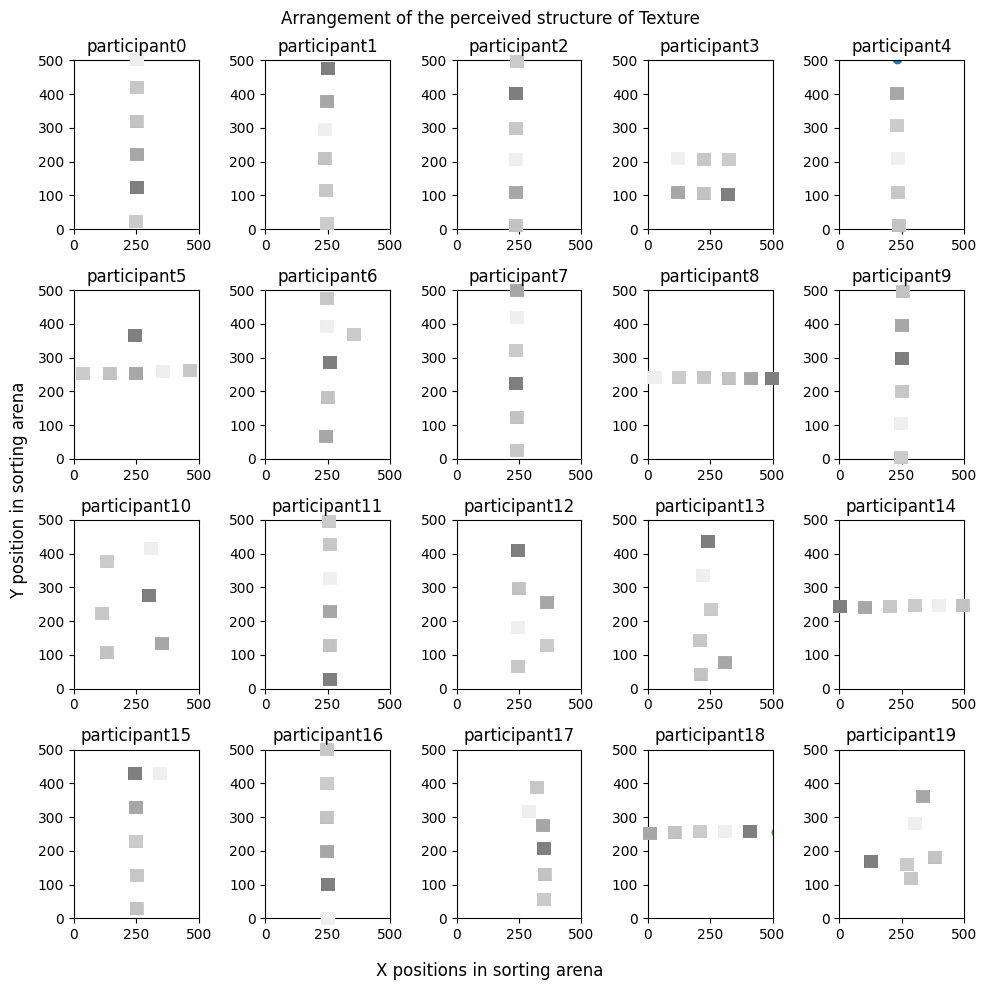

In [12]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]
cols = 5
rows = len(datasets) // cols
figsize = (10,10)
fig, axes = plt.subplots(rows, cols, figsize=figsize)
criteria_match = "Texture"



for index, participant in enumerate(datasets):
    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    plot_data = {}
    ax = axes.flatten()[index]

    #loop through all the objects and find the location data for the colours
    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            if criteria_match in data['src']:
                image = data['src']
                x = data['x']
                y = data['y']
                plot_data[image] = [x,y]
            else:
                continue


    #now loop through the plot data and plot them on their respective subplot
    for key in plot_data:
        image_path = key
        x_coord = plot_data[key][0]
        y_coord = plot_data[key][1]
        ax.set_title(f"participant{index}")
        ax.scatter(x_coord,y_coord)
        img =  Image.open(f"{image_path}")
        img.thumbnail((10,10))
        img_array = np.asarray(img)
        imagebox = OffsetImage(img_array,zoom=1)
        ax.set_xlim([0,500])
        ax.set_ylim([0,500])
        #this is the picture which gets overlayed on the scatter
        picture = AnnotationBbox(imagebox, (x_coord,y_coord), frameon=False)
        ax.add_artist(picture)


fig.suptitle(f"Arrangement of the perceived structure of {criteria_match}")
fig.supxlabel("X positions in sorting arena")
fig.supylabel("Y position in sorting arena")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

    


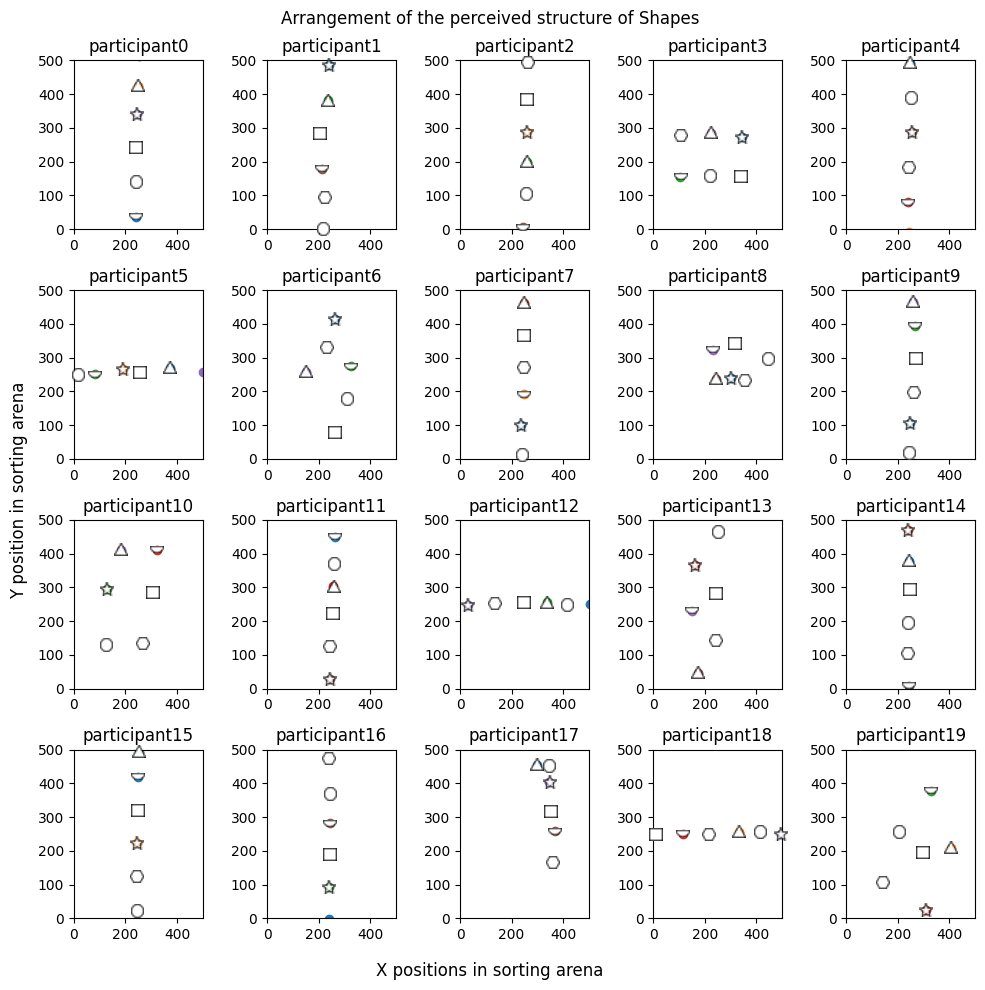

In [13]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]
cols = 5
rows = len(datasets) // cols
figsize = (10,10)
fig, axes = plt.subplots(rows, cols, figsize=figsize)
criteria_match = "Shapes"



for index, participant in enumerate(datasets):
    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    plot_data = {}
    ax = axes.flatten()[index]

    #loop through all the objects and find the location data for the colours
    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            if criteria_match in data['src']:
                image = data['src']
                x = data['x']
                y = data['y']
                plot_data[image] = [x,y]
            else:
                continue


    #now loop through the plot data and plot them on their respective subplot
    for key in plot_data:
        image_path = key
        x_coord = plot_data[key][0]
        y_coord = plot_data[key][1]
        ax.set_title(f"participant{index}")
        ax.scatter(x_coord,y_coord)
        img =  Image.open(f"{image_path}")
        img.thumbnail((10,10))
        img_array = np.asarray(img)
        imagebox = OffsetImage(img_array,zoom=1)
        ax.set_xlim([0,500])
        ax.set_ylim([0,500])
        #this is the picture which gets overlayed on the scatter
        picture = AnnotationBbox(imagebox, (x_coord,y_coord), frameon=False)
        ax.add_artist(picture)


fig.suptitle(f"Arrangement of the perceived structure of {criteria_match}")
fig.supxlabel("X positions in sorting arena")
fig.supylabel("Y position in sorting arena")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

    


In [ ]:
#loop through all session 1 and session 2 data 
#create a distance map
#filter df to only have choice trials and the preceding trial, so trial at choice_trial_index - 1
#inner loop to loop through all these rows
#store the choice trial preceding nodes from   from dist_color .. and dist_slow... etc.
#store the choice trial nodes from all the distractor dimensions
#compare node_preced with choice_trial_node, find the difference and check with the distance map to find the real distance between the nodes
#create a dictionary or something to store necessary entries to ensure faster run time (values from dist_color .. and dist_slow...)
#add columns distractor_distance_colour, distractor_distance_shape, distractor_distance_texture
#add columns distractor_distance_slow, distractor_distance_medium, distractor_distance_fast
#add values to columns


datasets = os.listdir("v2_secondrun_results")
distance_map = {
    0 : 0,
    1: 1,
    2: 2,
    3: 3,
    4 : 2,
    5 : 1
}
